# Voter ID Debate

This is a Notebook file with analyses of US Congressional Debates over __voter ID__. The analyses conducted are inductive and bottom up, meaning that the interest lies in recognising and interpreting patterns emerging from the data. 

Specifically these analyses aim to identify:
1. the topics voter ID is linked to.
2. the ways in which voter ID is framed by Democratic and Republican speakers.
3. how frames/topics around voter ID change over time.

It is split into the sections below:
- _Preprocessing_
    * Clean up: remove punctuation, convert to lower case
    * Remove common stop words
    * lemmatisation
    
- _Descriptive Statistics_
    * Most common words and wordcloud
    * Most common n-grams 
    * Number of speeches per Party and Congress

- Reducing corpus size and noise
    * remove stopwords using TF-IFG scores: to remove words that are not meaningful
    * Filter extremes: remove words that occur in less that n=5 documents or in more than 50% of all documents
    * Join common bigrams
 
- _Analyses_
    * Word embedding model (using the Word2vec implementation provided by the gensim package) and visualisation
    * Co-occurrence network
    * Temporal dimension: dynamic word embedding model, word embedding model per Congress

***

## Importing modules

In [ ]:
!pip install nltk
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
import re, nltk, numpy, matplotlib
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora

## Data

First we load the data, inspect it and remove columns we don't need:

In [ ]:
data = pd.read_csv("US_Debates_ngrams.csv")
data.head()
df = data.drop(columns=['Title', 'State', 'Volume', 'Where', 'Unnamed: 9', 'Unnamed: 11', 'Order']) # Remove columns
df. dropna() # Drop NA rows
len(df)

In [ ]:
text =df['text'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

## Preprocessing
Now we can start preprocessing, by tokenising the corpus, removing puctuation and common stopwords, and converting the text into lower case.

In [35]:
stop_words_file = 'english.stop.txt' # Stopword list

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)
    letters_only_text = letters_only_text.replace("voter fraud", "voter_fraud")
    letters_only_text = letters_only_text.replace("supreme court", "supreme_court")
    letters_only_text = letters_only_text.replace("madam speaker", "madam_speaker")
    letters_only_text = letters_only_text.replace("mr speaker", "mr_speaker")
    letters_only_text = letters_only_text.replace("african american", "african_american")
    letters_only_text = letters_only_text.replace("north carolina", "north_carolina")
    letters_only_text = letters_only_text.replace("united state", "united_states")

     # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # lemmatise words
    lemmatised_words = []
    for word in cleaned_words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word)  
        lemmatised_words.append(word)

    # converting list back to string
    return " ".join(lemmatised_words)

In [34]:
test_sentence = "this is a sentence to demonstrate how the preprocessing function works...! madam speaker"

preprocess(test_sentence)

'sentence demonstrate preprocessing function work madam_speaker'

In [36]:
df['text']=df['text'].apply(str) # Converting text column into string so that preprocessing works

df['prep'] = df['text'].apply(preprocess)
df.head()

,Date,Speaker,Party,text,Congress,we,prep
0,"Thursday, January 3, 2013",Ms. SLAUGHTER,Democratic,Under the cover of a cynical and untruthful cl...,113th,cover cynical untruthful claim voter fraud thr...,cover cynical untruthful claim voter_fraud thr...
1,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,"As a Member of this body, I firmly believe th...",113th,"member body, firmly protect right eligible cit...",member body firmly protect right eligible citi...
2,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,There have been several restrictive voting bi...,113th,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...
3,"Thursday, February 14, 2014",Mr. VEASEY,Democratic,As oral arguments are being prepared for the F...,113th,oral argument prepared february 27 u.s. suprem...,oral argument prepared february supreme court ...
4,"Monday, February 25, 2013",Mr. JEFFRIES,Democratic,Perhaps the most relevant example of why secti...,113th,relevant section 5 continues relevant due plac...,relevant section continues relevant due place ...


In [ ]:
# Checking amount of words after preprocessing
text =df['prep'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

In [ ]:
is_dem =  df['Party']=='Democratic'
dem = df[is_dem]
len(dem)

In [ ]:
is_rep =  df['Party']=='Republican'
rep = df[is_rep]
len(rep)

In [ ]:
text =dem['prep'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

In [ ]:
df.to_csv("preprocessed.csv") # save output to local machine

In [ ]:
# Below is the code to find and remove frequent and infrequent words - I wanted to include these as stopwords but its not ideal as most_common only works with n and not percentages, so its best to use CountVectorizer for this

# Finding and removing rare words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["stopfreqrare"] = df["prep"].apply(lambda text: remove_rarewords(text))
df.head()

# Remove very frequent words
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["stopfreq"] = df["prep"].apply(lambda text: remove_freqwords(text))
df.head()

## Descriptive stats

In [72]:
# Most frequent words
from collections import Counter
cnt = Counter()
for text in df["prep"].values:
    for word in text.split():
        cnt[word] += 1

# cnt = Counter(" ".join(df["prep"]).split(" ")).most_common(10) - another way of finding most common words in corpus

cnt.most_common(30)
cnt_df = pd.DataFrame(cnt.most_common(30))
cnt_df.columns=['word', 'freq']
cnt_df

,word,freq
0,state,3182
1,vote,2986
2,election,2907
3,voter,2747
4,voting,2371
5,american,1988
6,people,1895
7,law,1759
8,bill,1338
9,right,1186


In [65]:
# Displaying top words

import pandas as pd
import matplotlib.pyplot as plt
def scatterplot(df, x_dim, y_dim):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(10, 10))
  #customizes alpha for each dot in the scatter plot
  ax.scatter(x, y, alpha=0.70)
 
  #adds a title and axes labels
  ax.set_title('Word Frequencies')
  ax.set_xlabel('Frequency')
  ax.set_ylabel('Word')
 
  #removing top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  #adds major gridlines
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
  plt.show()

  #LEARN HOW TO SAVE PLOTS, plt.savefig('plot.png') saving black plot

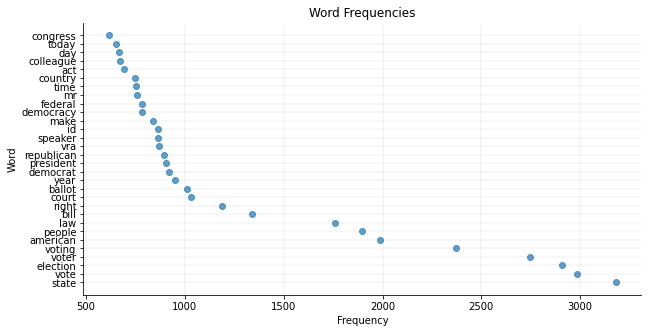

In [73]:
scatterplot(cnt_df, 'freq', 'word')

In [74]:
# find very infrequent words
cnt.most_common()[-10-1:-1]

[('transmission', 1),
 ('operator', 1),
 ('delicate', 1),
 ('activation', 1),
 ('obeying', 1),
 ('brazenly', 1),
 ('weakness', 1),
 ('blackmail', 1),
 ('dormancy', 1),
 ('capitulate', 1)]

In [68]:
# Find top bigrams with a frequency above 100
from nltk.util import ngrams
n_gram = 2
n_gram_dic = dict(Counter(ngrams(" ".join(df["bigram"]).split(), n_gram))) # Finding ngrams in corpus

for i in n_gram_dic:
    if n_gram_dic[i] >= 100:
        print(i, n_gram_dic[i])


('voter', 'id') 495
('id', 'law') 342
('cast', 'ballot') 103
('early', 'voting') 223
('minority', 'voter') 104
('election', 'day') 112
('voter', 'registration') 224
('african', 'american') 391
('state', 'local') 100
('election', 'law') 155
('photo', 'id') 136
('voting', 'right') 679
('polling', 'place') 131
('supreme', 'court') 462
('shelby', 'county') 184
('voter', 'suppression') 363
('year', 'ago') 142
('mr', 'speaker') 332
('civil', 'right') 214
('voting', 'law') 148
('united', 'state') 294
('john', 'lewis') 205
('american', 'vote') 133
('people', 'vote') 103
('north', 'carolina') 250
('ballot', 'box') 108
('madam', 'speaker') 455
('federal', 'government') 163
('state', 'legislature') 163
('federal', 'election') 169
('american', 'people') 268
('right', 'advancement') 108
('advancement', 'act') 108
('presidential', 'election') 103
('vote', 'mail') 103
('president', 'trump') 131
('mr', 'farr') 109
('ballot', 'harvesting') 118
('people', 'act') 146
('postal', 'service') 153


In [70]:
# Sorting ngrams by frequency
from nltk.util import ngrams
n_gram = 2
n_gram_dic = Counter(ngrams(" ".join(df["bigram"]).split(), n_gram)).most_common(40) # 20 most common ngrams
ngram = pd.DataFrame(n_gram_dic)
ngram.columns=['ngram', 'freq']
ngram

,ngram,freq
0,"(voting, right)",679
1,"(voter, id)",495
2,"(supreme, court)",462
3,"(madam, speaker)",455
4,"(african, american)",391
5,"(voter, suppression)",363
6,"(id, law)",342
7,"(mr, speaker)",332
8,"(united, state)",294
9,"(american, people)",268


Now that we know common bigrams we can go back to preprocessing and join these in the text so that they are subsequently treated as 1 token instead of 2. 
The following bigrams are joined:
- Supreme court
- Madam speaker
- Mr Speaker
- United States
- African American
- John Lewis

Mr Speaker and Madam speaker are removed from the corpus as they add little meaning

In [56]:
 def bigrams(raw_text):
    letters_only_text = raw_text.replace("supreme court", "supreme_court")
    letters_only_text = letters_only_text.replace("madam speaker", "madam_speaker")
    letters_only_text = letters_only_text.replace("mr speaker", "mr_speaker")
    letters_only_text = letters_only_text.replace("african american", "african_american")
    letters_only_text = letters_only_text.replace("north carolina", "north_carolina")
     # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # lemmatise words
    lemmatised_words = []
    for word in cleaned_words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word)  
        lemmatised_words.append(word)

    # converting list back to string
    return " ".join(lemmatised_words)

In [57]:
df['text']=df['text'].apply(str) # Converting text column into string so that preprocessing works

df['bigram'] = df['text'].apply(preprocess)
df.head()

,Date,Speaker,Party,text,Congress,we,prep,freq,bigram
0,"Thursday, January 3, 2013",Ms. SLAUGHTER,Democratic,Under the cover of a cynical and untruthful cl...,113th,cover cynical untruthful claim voter fraud thr...,cover cynical untruthful claim voter_fraud thr...,cover cynical claim voter_fraud threat democra...,cover cynical untruthful claim voter_fraud thr...
1,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,"As a Member of this body, I firmly believe th...",113th,"member body, firmly protect right eligible cit...",member body firmly protect right eligible citi...,member body firmly protect right eligible citi...,member body firmly protect right eligible citi...
2,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,There have been several restrictive voting bi...,113th,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...
3,"Thursday, February 14, 2014",Mr. VEASEY,Democratic,As oral arguments are being prepared for the F...,113th,oral argument prepared february 27 u.s. suprem...,oral argument prepared february supreme court ...,argument prepared february supreme court heari...,oral argument prepared february supreme court ...
4,"Monday, February 25, 2013",Mr. JEFFRIES,Democratic,Perhaps the most relevant example of why secti...,113th,relevant section 5 continues relevant due plac...,relevant section continues relevant due place ...,relevant section continues relevant due place ...,relevant section continues relevant due place ...


In [75]:
# Filtering words that appear less than 3 times overall, by (1) Splitting sentences into words, (2) Computing global word frequency, (3) Filtering words based on computed frequencies, (4) Joining and re-assigning
from collections import Counter
from itertools import chain

# split words into lists
v = df['prep'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
df['freq'] = [' '.join([j for j in i if c[j] > 3]) for i in v]

df.head()

,Date,Speaker,Party,text,Congress,we,prep,freq,bigram
0,"Thursday, January 3, 2013",Ms. SLAUGHTER,Democratic,Under the cover of a cynical and untruthful cl...,113th,cover cynical untruthful claim voter fraud thr...,cover cynical untruthful claim voter_fraud thr...,cover cynical claim voter_fraud threat democra...,cover cynical untruthful claim voter_fraud thr...
1,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,"As a Member of this body, I firmly believe th...",113th,"member body, firmly protect right eligible cit...",member body firmly protect right eligible citi...,member body firmly protect right eligible citi...,member body firmly protect right eligible citi...
2,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,There have been several restrictive voting bi...,113th,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...
3,"Thursday, February 14, 2014",Mr. VEASEY,Democratic,As oral arguments are being prepared for the F...,113th,oral argument prepared february 27 u.s. suprem...,oral argument prepared february supreme court ...,argument prepared february supreme court heari...,oral argument prepared february supreme court ...
4,"Monday, February 25, 2013",Mr. JEFFRIES,Democratic,Perhaps the most relevant example of why secti...,113th,relevant section 5 continues relevant due plac...,relevant section continues relevant due place ...,relevant section continues relevant due place ...,relevant section continues relevant due place ...


In [71]:
joined = " ".join(df['bigram'])
len(re.findall("supreme_court",joined))

16

In [77]:
!pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for wordcloud, since package 'wheel' is not installed.
    Running setup.py install for wordcloud: started
    Running setup.py install for wordcloud: finished with status 'error'


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\analo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\analo\\AppData\\Local\\Temp\\pip-install-17038a77\\wordcloud_805d38b0b9854fc985ba13476afb028b\\setup.py'"'"'; __file__='"'"'C:\\Users\\analo\\AppData\\Local\\Temp\\pip-install-17038a77\\wordcloud_805d38b0b9854fc985ba13476afb028b\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\analo\AppData\Local\Temp\pip-record-takd893n\install-record.txt' --single-version-externally-managed --user --prefix= --compile --install-headers 'C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Py

In [78]:
from pandas.core.frame import DataFrame
#nice library to produce wordclouds
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# if uising a Jupyter notebook, include:

all_words = '' 

#looping through all incidents and joining them to one text, to extract most common words
for arg in data["prep"]: 
    tokens = arg.split()  
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for wordcloud, since package 'wheel' is not installed.
    Running setup.py install for wordcloud: started
    Running setup.py install for wordcloud: finished with status 'error'


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\analo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\analo\\AppData\\Local\\Temp\\pip-install-i5nz5sxr\\wordcloud_37b943ef2b7b420092b40b1c7d64a1be\\setup.py'"'"'; __file__='"'"'C:\\Users\\analo\\AppData\\Local\\Temp\\pip-install-i5nz5sxr\\wordcloud_37b943ef2b7b420092b40b1c7d64a1be\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\analo\AppData\Local\Temp\pip-record-6hwf_8ki\install-record.txt' --single-version-externally-managed --user --prefix= --compile --install-headers 'C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Py

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
df['Party'].value_counts() # Counting speeches per Party

ax = data['Party'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(7,5))
ax.set_title('Party Speech Count\n', fontsize=20)
ax.set_xlabel('Publication', fontsize=18)
ax.set_ylabel('Count', fontsize=18);

In [ ]:
congress = df['Congress'].value_counts()
pd.DataFrame(congress)

In [ ]:
ax = df['Congress'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(7,5)) # Counting speeches per Congress
ax.set_title('Congress Speech Count\n', fontsize=20)
ax.set_xlabel('Congress', fontsize=18)
ax.set_ylabel('Statements', fontsize=18);

In [ ]:
df['prep']=df['prep'].apply(str)
from collections import Counter
my_counter = Counter()
all_words = '' #looping through all incidents and joining them to one text, to extract most common words
for arg in df["prep"]: 
    tokens = arg.split()  
    my_counter.update(tokens)

len(my_counter)

most_common_three = my_counter.most_common(3)
print(most_common_three)

In [43]:
text =df['freq'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

168878

## POS

In [ ]:
import nltk
tagged = nltk.pos_tag(my_counter)
print(tagged)

### TF-IDF scores instead of word counts as features
Use (a) the frequency of each word in the corpus and (b) the number of documents in which the document occurs. So use tf-idf scores (term frequency weighed by the inverse document frequency) instead of raw word counts as features, the stopwords should disappear automatically.

In [ ]:
text = df['prep'] # setting 'text' as the preprocessed corpus
orig = df['text']


While cv.fit(...) would only create the vocabulary, cv.fit_transform(...) creates the vocabulary and returns a term-document matrix which is what we want. With this, each column in the matrix represents a word in the vocabulary while each row represents the document in our dataset where the values in this case are the word counts. Note that with this representation, counts of some words could be 0 if the word did not appear in the corresponding document.

We ignore all words that have appeared in 95% of the documents, since those may be unimportant.

In [ ]:
# ignore words that appear in 95% of documents and in less that 1% of documents,
cv=CountVectorizer(max_df=0.95, min_df =0.01)
word_count_vector=cv.fit_transform(text)

word_count_vector

In [ ]:
list(cv.vocabulary_.keys())[:10] #10 words from our vocabulary.

It’s now time to compute the IDF values. In the code below, we are essentially taking the sparse matrix from CountVectorizer (word_count_vector) to generate the IDF when you invoke tfidf_transformer.fit(...)(see: basic usage example of tfidftransformer and tfidfvectorizer).
Once we have our IDF computed, we are now ready to compute TF-IDF and then extract top keywords from the TF-IDF vectors. Now we are going to compute the IDF values. IDF values are be sorted in descending order. The lower the IDF value of a word, the less unique it is to any particular document.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

In [ ]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])[:10]

## LDA Topic Model

In [ ]:
!pip install gensim
from gensim import corpora
from gensim import models

In [ ]:
# to avoid messing things up, I'll call all objects relating to our first model _m1
ldainput = [text.split() for text in text]           # convert all strings to list of words
id2word = corpora.Dictionary(ldainput)                       # assign a token_id to each word
ldacorpus = [id2word.doc2bow(doc) for doc in ldainput] 

In [ ]:
lda = models.LdaModel(ldacorpus, id2word=id2word, num_topics=10)
lda.print_topics()

In [ ]:
# Use tf-idf scores to remove corpus related stopwords
tfidfcorpus = models.TfidfModel(ldacorpus)
lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus[ldacorpus],id2word=id2word,num_topics=10)
lda_m3.print_topics(num_words=5)

In [ ]:
# Filter extremes     
id2word.filter_extremes(no_below=5)
ldacorpus = [id2word.doc2bow(doc) for doc in ldainput]
tfidfcorpus = models.TfidfModel(ldacorpus)
lda_m4 = models.ldamodel.LdaModel(corpus=tfidfcorpus[ldacorpus],id2word=id2word,num_topics=10)
lda_m4.print_topics(num_words=5)

## Co-occurrence networks

In [ ]:
# Step 1: preprocess
stop_words_file = 'english.stop.txt' # Stopword list

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess_we(raw_text):
     # convert to lower case and split into words -> convert string into list
    words = raw_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word)  
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [ ]:
rep.head()

In [ ]:
# Creating co-occurrence matrix
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,1), max_df=0.75, min_df =0.05) # You can define your own parameters
X = cv.fit_transform(rep['we'])

In [ ]:
Xc = (X.T * X) # This is the matrix manipulation step
Xc.setdiag(0) # We set the diagonals to be zeroes as it's pointless to be 1

In [ ]:
# we turn it into a pandas DataFrame and export it as a CSV.
import pandas as pd
names = cv.get_feature_names_out() # This are the entity names (i.e. keywords)
rep_net = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
rep_net.to_csv('to gephi.csv', sep = ',')
